# Offline Phase

**Aim of the tutorial:** this notebook shows how to perform the offline phase of the POD algorithm, i.e. how to use this method to generate the basis functions and the generation of suitable maps for the reduced coefficients in the framework of the POD with Interpolation to be used during the online phase.

In particular, the basis functions (named *modes*) are generated through the POD procedure, the maps between parameters and reduced coefficients are created and, in the end, the modes are plotted using `pyvista`.

-------------------------------------------

*To execute this notebook* it is necessary to have the snapshots stored in `Snapshots` folder, placed in this directory (otherwise modify `path_FOM` variable).

In [1]:
import os
from IPython.display import clear_output
import numpy as np

from dolfinx.fem import FunctionSpace
from pyforce.offline.pod import POD
import ufl

import matplotlib.pyplot as plt
from matplotlib import cm

from pyforce.tools.functions_list import FunctionsList, train_test_split
from pyforce.tools.write_read import StoreFunctionsList as store, ImportH5


path='./Offline_results/'
if not os.path.exists(path):
    os.makedirs(path)

The geometry can be either generated directly in this notebook or loaded from a file.

**Disclaimer**: we have noticed that the degrees of freedom (dofs) of the mesh can vary according to the adopted operating system: for instance, if run on MacOS the dofs are 2356, whereas on Linux machines they are 2385. This is due to the fact that the mesh is generated through the `gmsh` library, which can produce different results on different platforms. 

*If an error occurs, please check the number of dofs and adjust the code accordingly: if the snapshots have been downloaded from [Zenodo](https://zenodo.org/records/11483677) it is suggested to load the `msh` file; otherwise, if the snapshots hase been generated locally, the `use_msh` option must be set to `False`.*

In [2]:
from ns import create_dfg2_mesh

# Snapshots downloaded
# domain = create_dfg2_mesh(mesh_factor=0.5, use_msh=True)[0]

# Snapshots generated locally
domain = create_dfg2_mesh(mesh_factor=0.5, use_msh=False, save_mesh=False)[0]

clear_output()

## Importing Snapshots

The snapshots are loaded and stored into suitable data structures.

Defining the functional space

In [3]:
fun_spaces = [FunctionSpace(domain, ("Lagrange", 1)),
              FunctionSpace(domain, ufl.VectorElement("Lagrange", domain.ufl_cell(), 1))]

Defining the variables to load

In [4]:
var_names = [
             'p',
             'u'
             ]

tex_var_names = [
                 r'p',
                 r'\mathbf{u}'
                 ]

Let us load the snapshots from the approapriate folder and let us extract the train set using random split.

In [5]:
path_FOM = './Snapshots/' 

train_snaps = list()
train_params = list()

for field_i in range(len(var_names)):

    tmp_FOM_list, tmp_param = ImportH5(fun_spaces[field_i], path_FOM+'snaps_'+var_names[field_i], var_names[field_i])
    
    res = train_test_split(tmp_param, tmp_FOM_list, test_size=0.25)
    
    train_params.append(res[0])
    train_snaps.append(res[2])
    
    del tmp_FOM_list, tmp_param

## POD algorithm

A list will be created for each POD with the indices consistent with the `var_names` variable, i.e., $0 = p,\; 1 = \mathbf{u}$.

**How does the POD work?**

Let $u(\mathbf{x};\boldsymbol{\mu})$ be a generic field dependent on space $\mathbf{x}\in\Omega\subset\mathbb{R}^d$ ($d=\{2,3\}$) and parameters $\boldsymbol{\mu}\in\mathcal{D}\subset\mathbb{R}^p$ ($p\geq 1$), let $u_n$ be snapshot for $\boldsymbol{\mu}_n$, i.e. $u_n=u(\mathbf{x}; \boldsymbol{\mu}_n)$.

The train set $\Xi_{train}\subset\mathcal{D}$ is composed by $N_s$ snapshots, i.e. $\Xi_{train} = \{\boldsymbol{\mu}_1, \ldots, \boldsymbol{\mu}_{N_s}\}$.

1. The correlation matrix $\mathbb{C}\in\mathbb{R}^{N_s\times N_s}$ is computed through
\begin{equation*}
\mathbb{C}_{nm} = (u_n, u_m)_{L^2(\Omega)} = \int_{\Omega} u_n\cdot u_m\,d\Omega\qquad n,m = 1, \dots, N_s
\end{equation*}

2. The eigendecomposition of the correlation matrix $\mathbb{C}$ is performed, given $\boldsymbol{\eta}_m$ be the eigenvector and $\lambda_m$ the associated eigenvalue
\begin{equation*}
\mathbb{C} \boldsymbol{\eta}_m = \lambda_m \boldsymbol{\eta}_m\qquad m = 1, \dots, N_s
\end{equation*}

3. The basis functions $\psi_m$ (POD modes) are computed through the following
\begin{equation*}
\psi_m = \frac{1}{\sqrt{\lambda_m}}\sum_{n=1}^{N_s} \eta_{m,n}\cdot u_n
\end{equation*}

### Decay of the POD eigenvalues

The offline `POD` class is used to compute the POD eigenvalues, eigenvectors and associated modes (i.e., basis functions).

The essential input of the `POD` class is the `FunctionsList` object, which contains the train snapshots (for each field, $p$ and $\mathbf{u}$) and the name of the variable to reduce. The initialisation of the `POD` class will compute the correlation matrix and the eigendecomposition, described above in points 1 and 2.
The option `verbose` can be activated to either show or not the progress bar.

In [6]:
pod_data = [POD(train_snaps[field_i], var_names[field_i], 
                verbose = True) 
            for field_i in range(len(var_names))]

Computing p correlation matrix: 480.000 / 480.00 - 0.093 s/it
Computing u correlation matrix: 480.000 / 480.00 - 0.121 s/it


Let us plot the eigenvalues

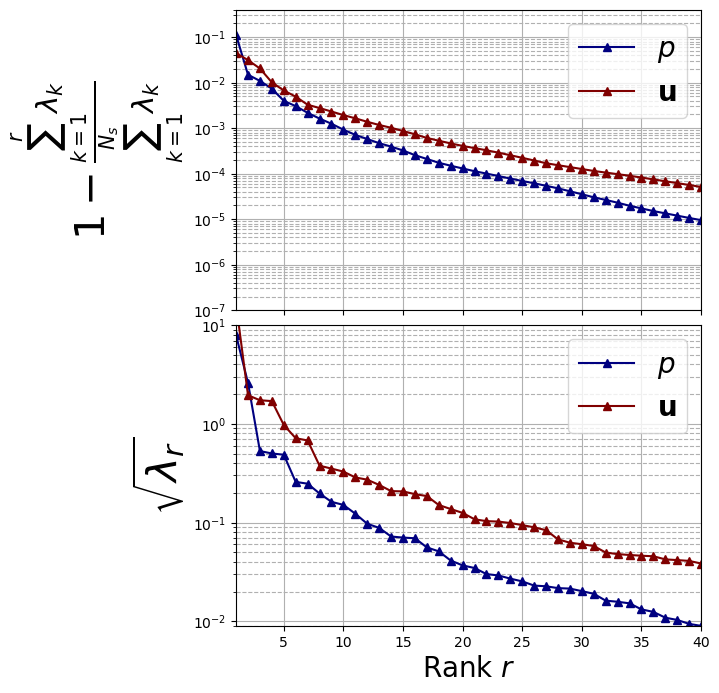

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

color = iter(cm.jet(np.linspace(0, 1, len(var_names))))

# Plot on the first subplot
for field_i in range(len(var_names)):
    c = next(color)
    axs[0].semilogy(
        np.arange(1, pod_data[field_i].eigenvalues.size + 1, 1),
        1 - np.cumsum(pod_data[field_i].eigenvalues) / sum(pod_data[field_i].eigenvalues),
        "-^", c=c, label="$" + tex_var_names[field_i] + "$", linewidth=1.5
    )
    
    axs[1].semilogy(
        np.arange(1, pod_data[field_i].eigenvalues[:40].size + 1, 1),
        np.sqrt(pod_data[field_i].eigenvalues[:40]),
        "-^", c=c, label="$" + tex_var_names[field_i] + "$", linewidth=1.5
    )

axs[0].set_ylabel(r"$1- \frac{\sum_{k=1}^{r}\lambda_k}{\sum_{k=1}^{N_s} \lambda_k}$", fontsize=30)
axs[0].set_ylim(1e-7, .4)

axs[1].set_ylabel(r"$\sqrt{\lambda_r}$", fontsize=30)
axs[1].set_ylim(9e-3, 10)

for ax in axs:
    ax.set_xticks(np.arange(0, 40 + 1, 5))
    ax.set_xlim(1, 40)
    ax.grid(which='major', linestyle='-')
    ax.grid(which='minor', linestyle='--')
    ax.legend(fontsize=20)

axs[1].set_xlabel(r"Rank $r$", fontsize=20)
    
fig.subplots_adjust(hspace=0.05)

### Definition of the modes
Let us compute the POD modes using the formula of step 3.

$N_{max}=30$ has been chosen by analysing the decay of the eigenvalues: in fact, the 99.99% of the information content is contained in the first 30 modes.

The method `compute_basis` computes the POD modes, starting from already computed pairs of eigenvalues and eigenvectors and the train snapshots. The option `normalise` is used to enforce the normalization of the modes with respect to the $L^2$ norm (due to some numerical errors).

In [8]:
Nmax = 30

for ii in range(len(var_names)):
    pod_data[ii].compute_basis(train_snaps[ii], Nmax, normalise = True)

We can now store them using `StoreFunctionsList` function of *pyforce*.
This step is very important, since the modes will be used in the online phase to reconstruct the solution using the following linear combination

\begin{equation*}
u(\mathbf{x};\boldsymbol{\mu}) \approx \sum_{m=1}^{N_{max}} \alpha_m(\boldsymbol{\mu})\cdot\psi_m(\mathbf{x})
\end{equation*}

where $\alpha_m(\boldsymbol{\mu})$ are the reduced coefficients.

The modes are stored in `Offline_results/BasisFunctions` folder.

In [9]:
if not os.path.exists(path+'BasisFunctions'):
    os.makedirs(path+'BasisFunctions')

for ii in range(len(var_names)):
    store(domain, pod_data[ii].PODmodes, 'POD_' +var_names[ii], path+'BasisFunctions/basisPOD_' + var_names[ii])

### Computing the training error
Then, we need to assess the performance of the POD basis generated in the previous cells. The reduced coefficients $\alpha_m(\boldsymbol{\mu})$ can be obtained from the train snapshots using $L^2$ projection: given a function $u(\mathbf{x};\boldsymbol{\mu}_n)$ with $\boldsymbol{\mu}_n\in\Xi_{train}$, the reduced coefficients can be computed with

\begin{equation*}
\alpha_m(\boldsymbol{\mu}_n) = (\psi_m, u(\mathbf{x};\boldsymbol{\mu}_n))_{L^2(\Omega)} = \int_{\Omega} \psi_m\cdot u(\mathbf{x};\boldsymbol{\mu}_n)\,d\Omega
\end{equation*}

The method `train_error` computes the $L^2$ error between the original snapshots and the reconstructed ones using the POD basis functions: it takes as input the train snapshots and the maximum number of modes to consider.

In [10]:
train_PODcoeff = []

idx_algo = 0
train_abs_err = np.zeros((Nmax, len(var_names)))
train_rel_err = np.zeros((Nmax, len(var_names)))

for ii in range(len(var_names)):
    tmp = pod_data[ii].train_error(train_snaps[ii], Nmax, verbose = True)

    train_abs_err[:, ii] = tmp[0].flatten()
    train_rel_err[:, ii] = tmp[1].flatten()
    
    train_PODcoeff.append(tmp[2])

Computing train error p: 480.000 / 480.00 - 0.053 s/it
Computing train error u: 480.000 / 480.00 - 0.050 s/it


The max absolute and relative reconstruction error is compared for the different fields, given the following definitions
\begin{equation*}
\begin{split}
E_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\\
\varepsilon_N[u] &= \max\limits_{\boldsymbol{\mu}\in\Xi^{train}} \frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}
\end{split}
\end{equation*}
given $\mathcal{P}_N$ the reconstruction operator with $N$ basis functions (takes the reduced coefficients generated by the $L^2$ projection and performs the linear combination of the modes).

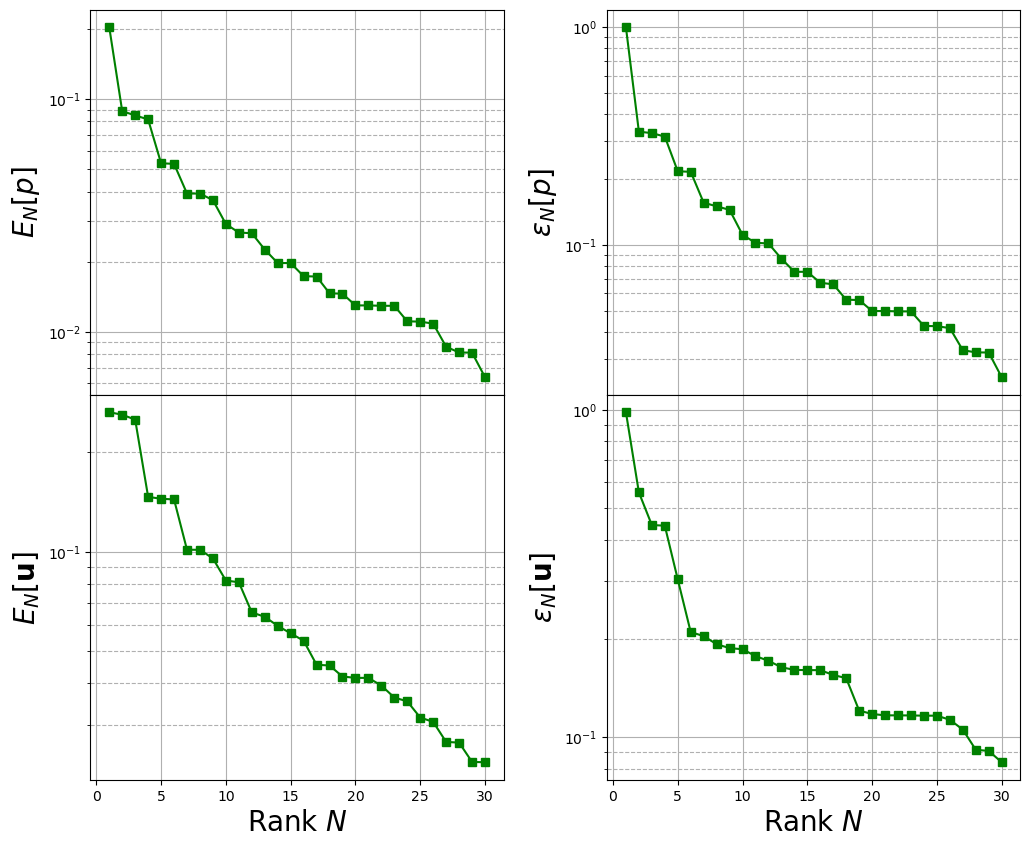

In [11]:
TrainingErrFig, axs = plt.subplots(nrows = len(var_names), ncols = 2, sharex = True, figsize = (12,10) )

Nmax = 30
M = np.arange(1,Nmax+1,1)

for ii in range(len(var_names)):
    
    axs[ii, 0].semilogy(M, train_abs_err[:Nmax, ii], 'g-s',   label = r'POD')
    axs[ii, 1].semilogy(M, train_rel_err[:Nmax, ii], 'g-s',   label = r'POD')

    axs[ii, 0].set_ylabel(r"$E_N["+tex_var_names[ii]+"]$",fontsize=20)
    axs[ii, 1].set_ylabel(r"$\varepsilon_N["+tex_var_names[ii]+"]$",fontsize=20)
    
axs[1, 0].set_xlabel(r"Rank $N$",fontsize=20)
axs[1, 1].set_xlabel(r"Rank $N$",fontsize=20)
    
for ax in axs.flatten():
    ax.grid(which='major',linestyle='-')
    ax.grid(which='minor',linestyle='--')   

TrainingErrFig.subplots_adjust(hspace = 0, wspace=0.25)

## Generation of the maps

In this section, the maps between the parameters $\boldsymbol{\mu}$ and the POD coefficients $\alpha_m$, associated to the POD mode $\psi_m$, are generated through the following methods from the `scipy` package:

- Linear Interpolation
- Radial Basis Function Interpolation

Since the snapshots are randomly sampled, it is better to sort them (required by some interpolation methods) with respect to the input parameter, which is the time in this case.

In [12]:
train_pod_coeff = list()
coeff_maps = list()

for field_i in range(len(var_names)):
    idx_sorting = np.argsort(train_params[field_i])
    train_pod_coeff.append({'X': np.take(train_params[field_i], idx_sorting),
                            'Y': train_PODcoeff[field_i][idx_sorting]})
    
    coeff_maps.append(dict())

### Linear Interpolation
Given the training data, the map $t\longrightarrow \alpha_m(t)$ is built through piecewise linear interpolation.

In [13]:
from scipy.interpolate import interp1d

for field_i in range(len(var_names)):
        coeff_maps[field_i]['LinInt'] = [interp1d(train_pod_coeff[field_i]['X'].flatten(), 
                                        train_pod_coeff[field_i]['Y'][:, rank].flatten(),
                                        kind = 'linear', fill_value = 'extrapolate')
                                        for rank in range(Nmax)]

### Radial Basis Function Interpolation
Given the training data, the map $t\longrightarrow \alpha_m(t)$ is built through Radial Basis Function interpolation.

In [14]:
from scipy.interpolate import RBFInterpolator

for field_i in range(len(var_names)):
        coeff_maps[field_i]['RBF'] = [RBFInterpolator( train_pod_coeff[field_i]['X'].reshape(-1,1),
                                                       train_pod_coeff[field_i]['Y'][:, rank].reshape(-1,1))
                                      for rank in range(Nmax)]

### Plotting the maps
For each field, the maps of the coefficients are plotted.

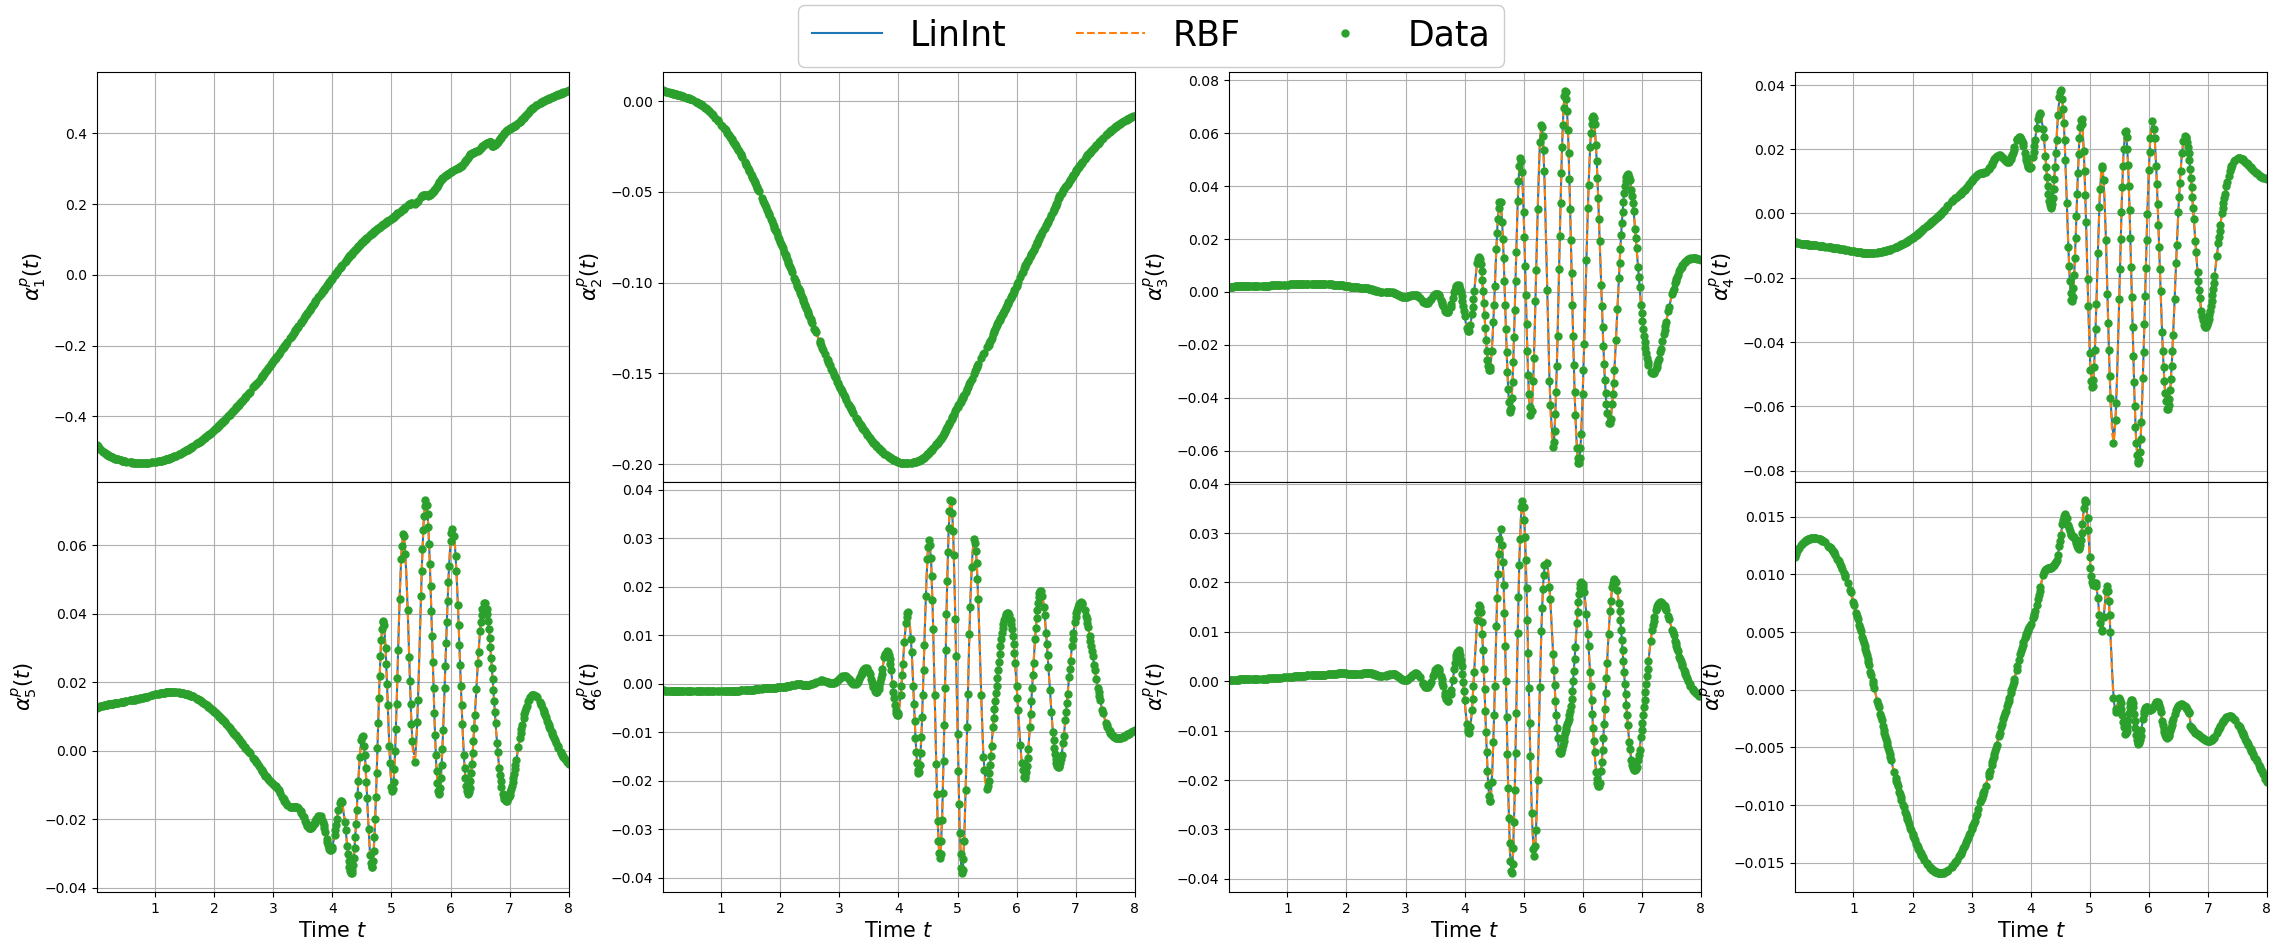

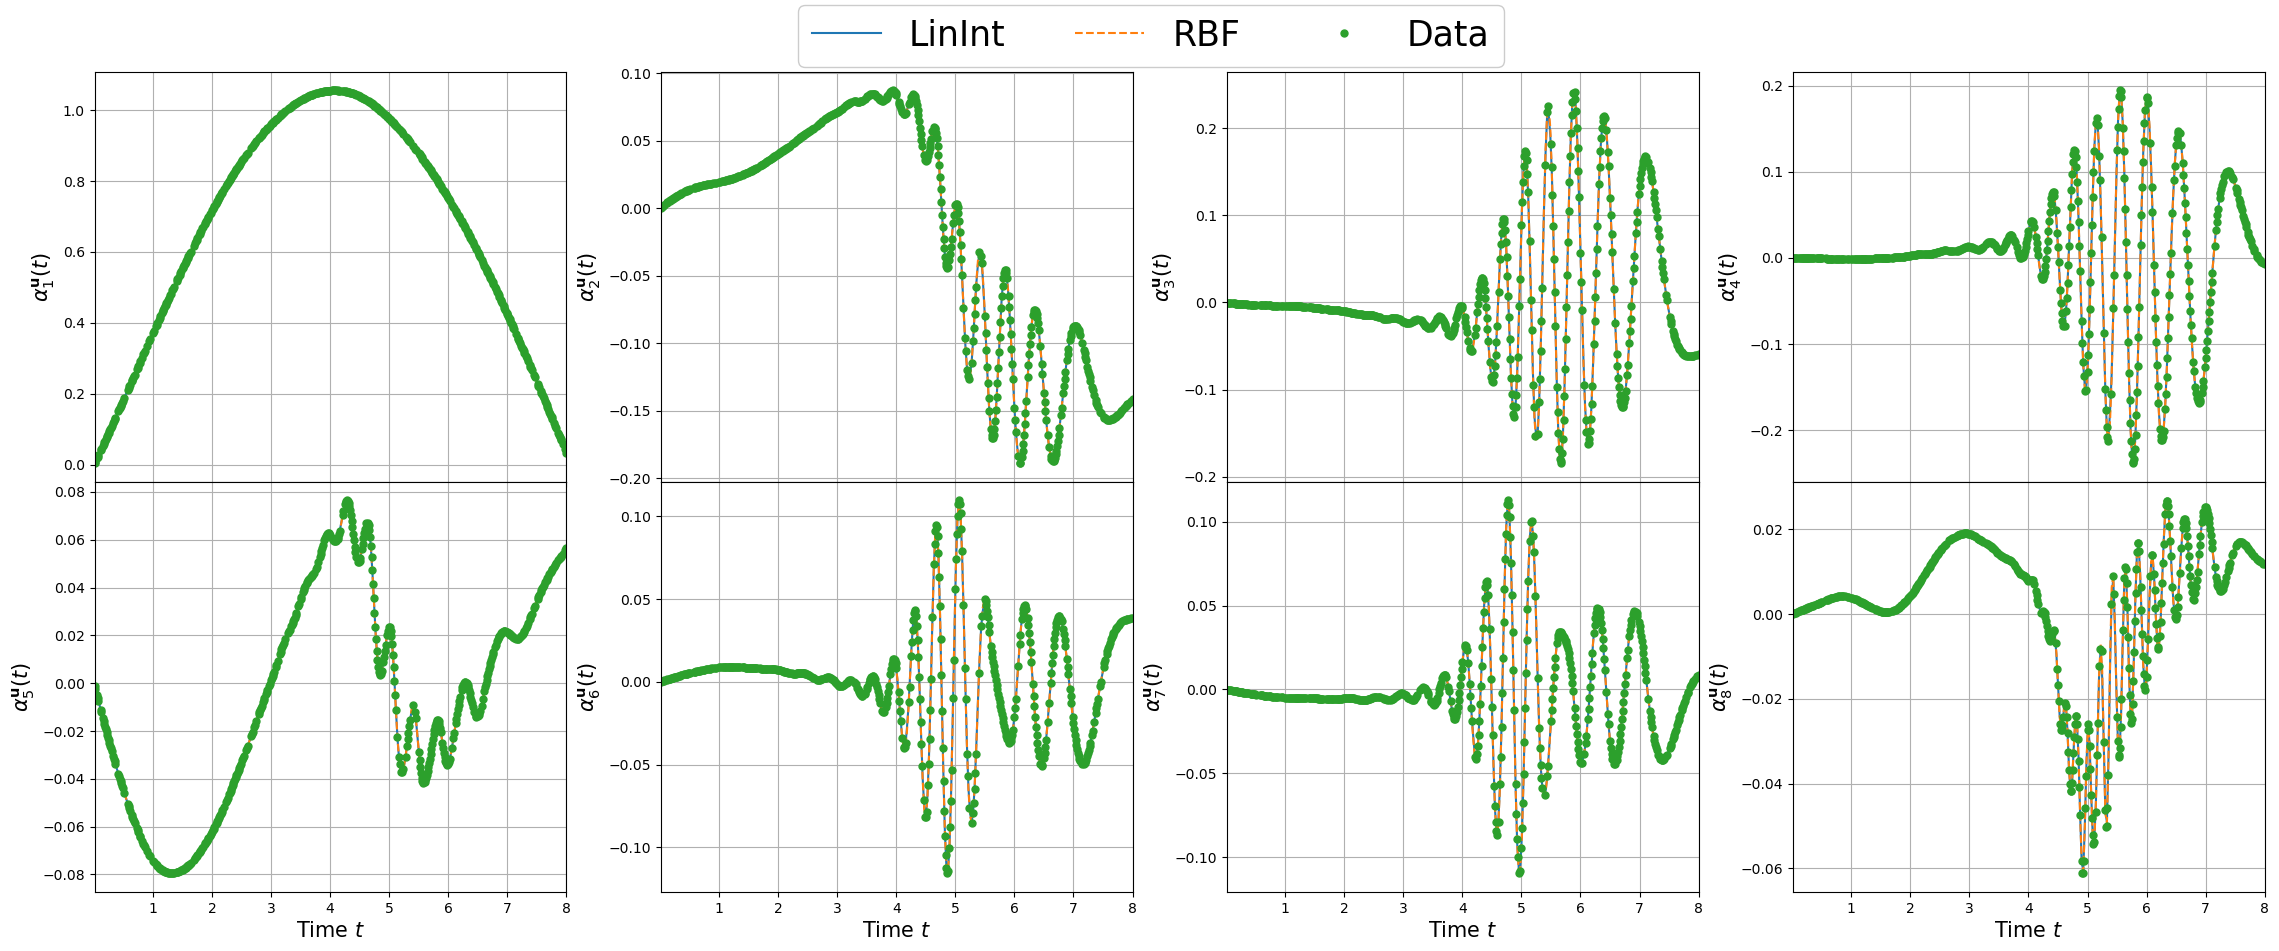

In [19]:
linestyles = ['-', '--', '-.', ':']

nrows = 2
ncols = 4

_x = np.linspace(min(train_pod_coeff[field_i]['X']), max(train_pod_coeff[field_i]['X']), 300)

for field_i in range(len(var_names)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 5*nrows), sharex=True)

    rank = 0
    for row in range(nrows):
        for col in range(ncols):
            for key_i, key in enumerate(list(coeff_maps[field_i].keys())):
                axs[row, col].plot(_x, coeff_maps[field_i][key][rank](_x.reshape(-1,1)), linestyles[key_i], label = key)
            
            axs[row, col].plot(train_pod_coeff[field_i]['X'], train_pod_coeff[field_i]['Y'][:, rank], 'o', markersize=5, label = 'Data')
            
            axs[row, col].grid()
            axs[row, col].set_xlim(min(_x), max(_x))
            axs[row, col].set_ylabel(r'$\alpha_{'+str(rank+1)+'}^'+tex_var_names[field_i]+'(t)$', fontsize=15)
            rank += 1
    
    [axs[-1, col].set_xlabel(r'Time $t$', fontsize=15) for col in range(ncols)]
            
    Line, Label = axs[0,0].get_legend_handles_labels()    
    fig.legend(Line, Label, framealpha = 1, fontsize=25, loc=(0.35, 0.93), ncols=3)

    fig.subplots_adjust(hspace=0, wspace=0.2, top = 0.93)
    plt.show()

Let us store the maps using *pickle* to use them during the online phase.

In [20]:
import pickle

pickle.dump(coeff_maps, open(path+'/pod_coeff.maps', 'wb'))
pickle.dump(train_pod_coeff, open(path+'/train_pod_coeff.sorted', 'wb'))

## Post Process: plotting the POD modes
In this last section, *pyvista* is used to make some contour plots of the POD modes for both pressure and velocity.

Let us plot the first 6 POD modes of each variable: in particular, a contour plot of the pressure ones and a vector plot of the velocity ones are shown.

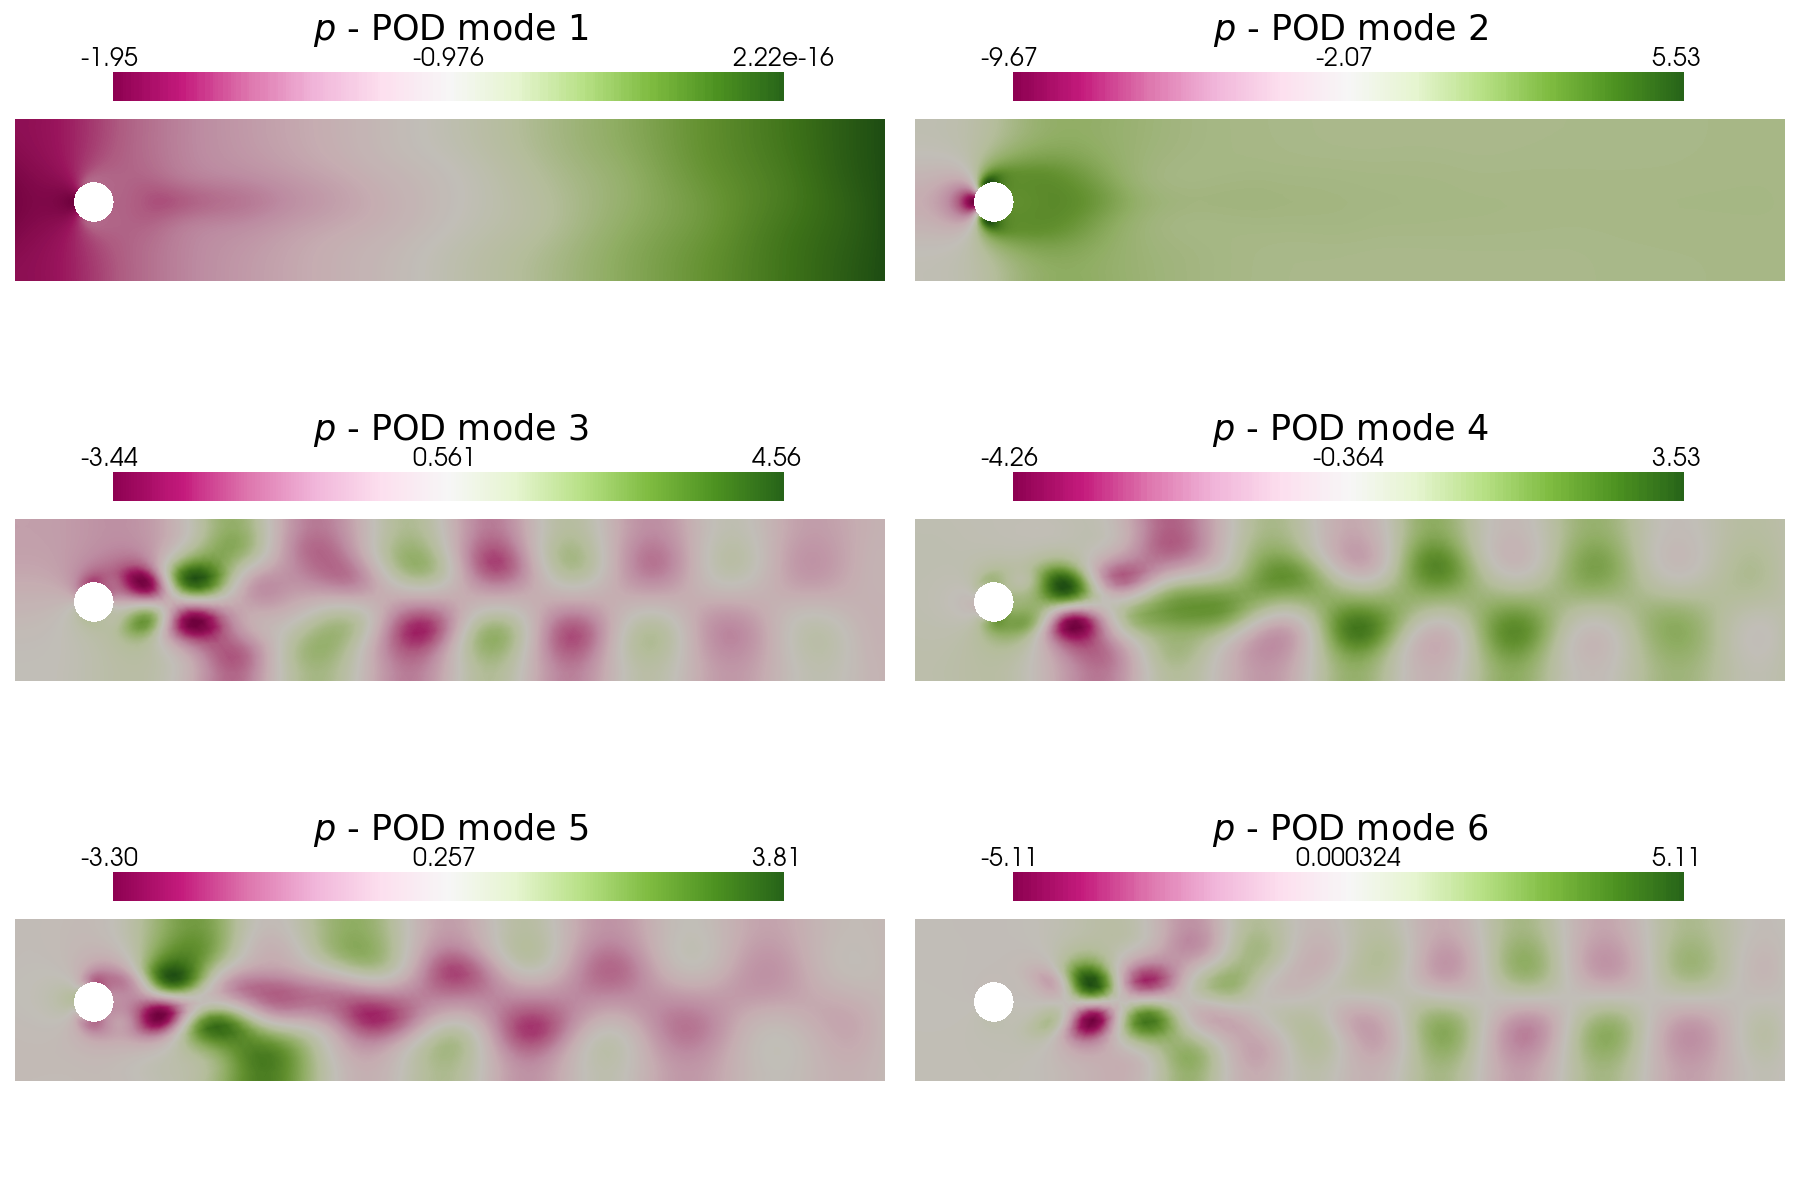

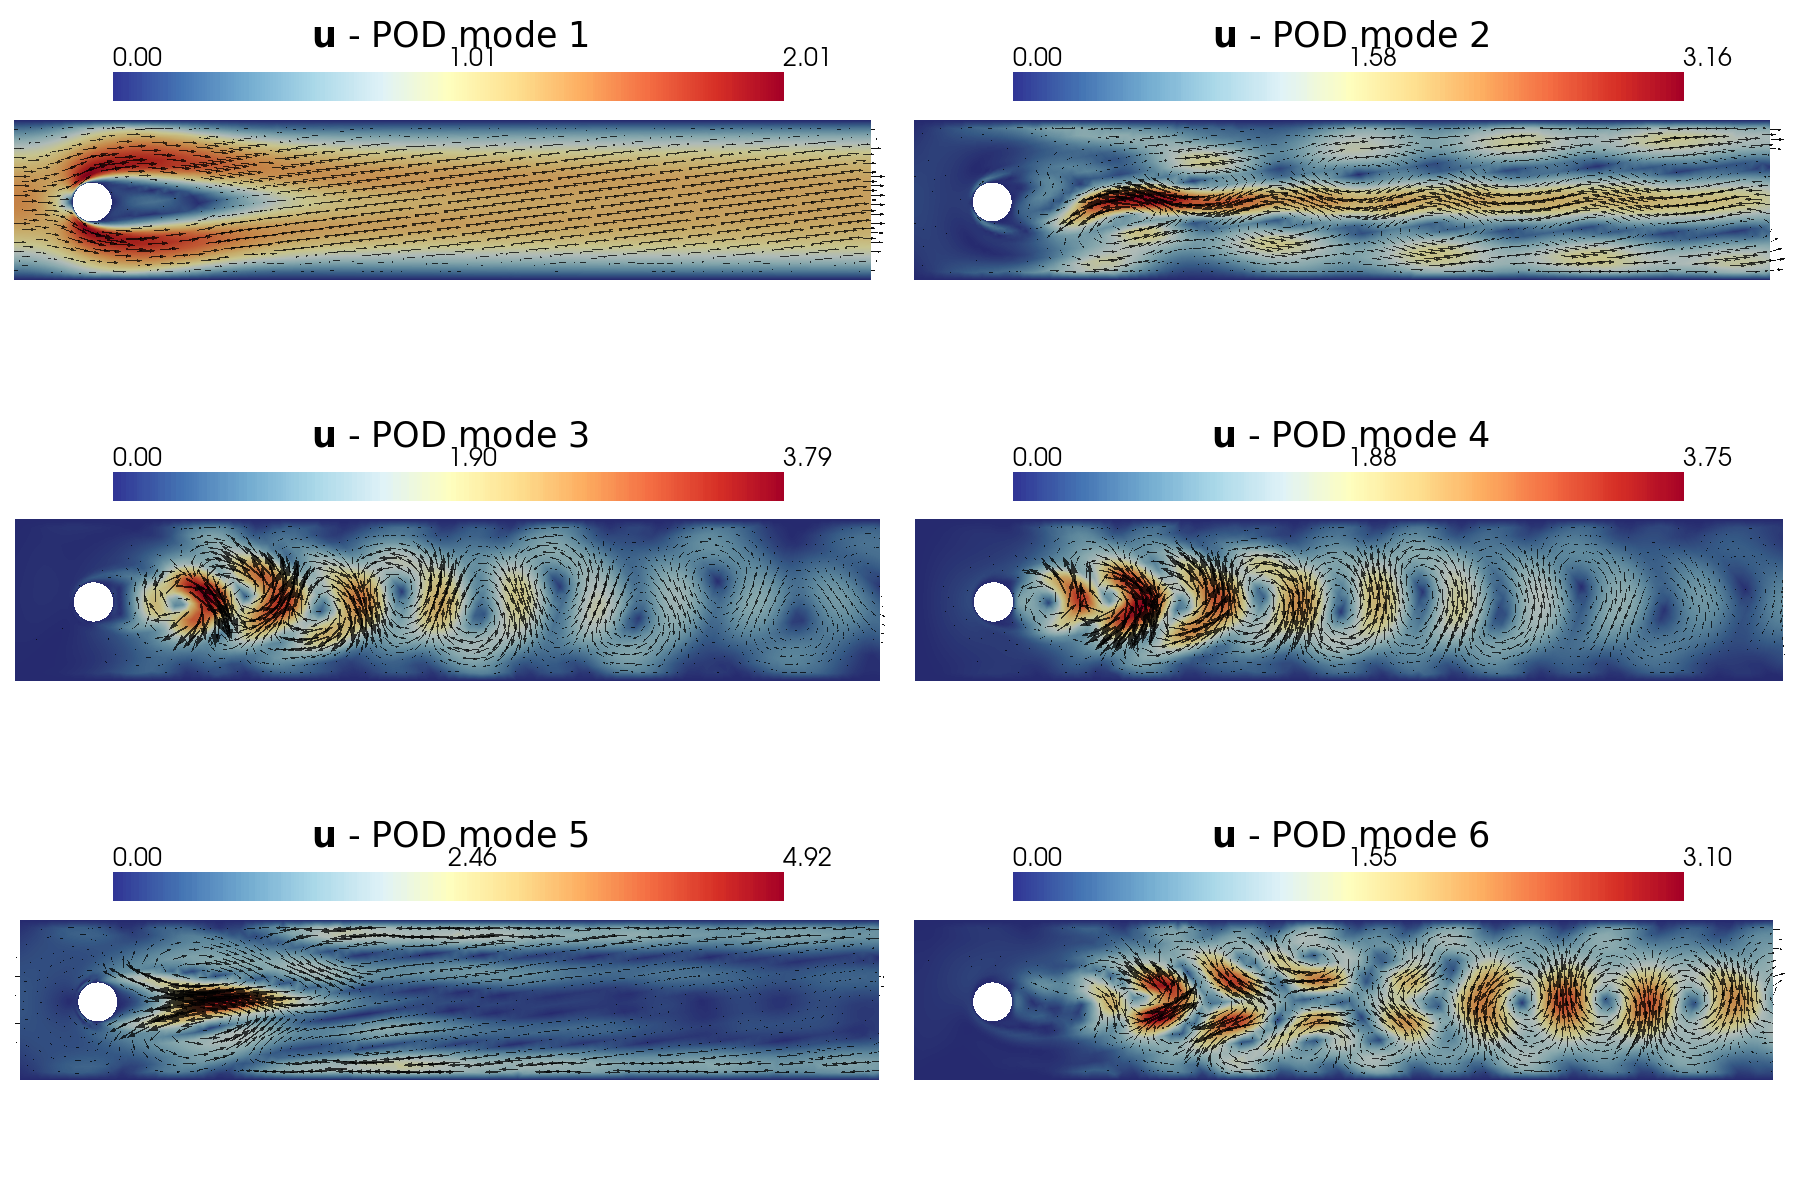

In [35]:
from contour_plotting import plot_modes

plot_modes(pod_data[0].PODmodes, tex_var_names[0], shape = [3,2], colormap=cm.PiYG)
plot_modes(pod_data[1].PODmodes, tex_var_names[1], shape = [3,2], mag_plot = False, colormap=cm.RdYlBu_r,
           factor = 0.03, tolerance = 0.01)